## Objectif:

Le projet consiste à prédire le mouvement du marché boursier en se basant sur les gros titres publiées un jour donné. Les données d'actualités ont été prises chaque jour ainsi que les données boursières du DJIA (Dow Jones Industrial Average), du 08/08/2008 jusqu'au 01/07/2016. Mon approche est d’analyser les titres et d’extraire les émotions en les quantifiant avec la technique nommée  NLP (Natural language processing), les librairies python (TextBlob et VaderSentiment) seront utilisées pour ce but.
C'est un problème de classification machine learning, deux classes seront traitées (mouvement ascendant: 0, mouvement descendant: 1). J'appliquerai plusieurs algorithmes de classification qui seront comparés grâce à la métrique f1_score ainsi que le roc_auc.


## Chargement des librairies utilisées 

In [1]:
import re 

import pandas as pd
import numpy as np

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Chargement des données

In [2]:
# le dataset se compose de deux fichiers:
#    1. le premier : un fichier contenant les données journalier relatives à l'indice boursier Dow Jones Industrial Average:
#           - Open     : la valeur d'ouveture
#           - High     : la valeur le plus haute
#           - Low      : la valeur la plus basse 
#           - Close    : la valeur de cloture 
#           - Volume   : le nombre d'actions échangées
#           - Adj Close: refléte la valeur de cette action après la prise en compte des opérations sur titres.
#    2. le deuxième : un ensemble de 25 titres de nouvelle du même jour, ainsi que le label.

df_stock = pd.read_csv('datasets/upload_DJIA_table.csv')
df_news  = pd.read_csv('datasets/Combined_News_DJIA.csv')
print("df_stock shape :", df_stock.shape)
print("df_news shape :", df_news.shape)

df_stock shape : (1989, 7)
df_news shape : (1989, 27)


In [3]:
df_stock.head(3)

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688


In [4]:
df_news.head(3)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."


## Données manquantes

In [5]:
print(df_stock.isnull().sum())
print('\n\n')
print(df_news.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64



Date     0
Label    0
Top1     0
Top2     0
Top3     0
Top4     0
Top5     0
Top6     0
Top7     0
Top8     0
Top9     0
Top10    0
Top11    0
Top12    0
Top13    0
Top14    0
Top15    0
Top16    0
Top17    0
Top18    0
Top19    0
Top20    0
Top21    0
Top22    0
Top23    1
Top24    3
Top25    3
dtype: int64


In [6]:
df_news['Top23'].fillna("",inplace=True)
df_news['Top24'].fillna("",inplace=True)
df_news['Top25'].fillna("",inplace=True)

## Nettoyage des données

In [7]:
DJIA = df_news.merge(df_stock, how='inner', on='Date', left_index=True)

In [8]:
headlines = []

for row in range(0, len(DJIA.index)):
    headlines.append(''.join(str(x) for x in DJIA.iloc[row, 2:27]))

In [9]:
clean_headlines = []

for i in range(0, len(headlines)):
    clean_headlines.append(re.sub("b[(')]", '', headlines[i]))
    clean_headlines[i] = re.sub('b[(")]', '', clean_headlines[i])
    clean_headlines[i] = re.sub("\[(')]", '', clean_headlines[i])

In [10]:
DJIA['Conbined_news'] = clean_headlines

## Mesurer les émotions dans le texte

### Text Blob:

- Les phrases subjectives se réfèrent généralement à une opinion, une émotion ou un jugement personnels, tandis que l'objectif se réfère à des informations factuelles. La subjectivité est également un flottant qui se situe dans la plage de [0,1].

- La polarité est flottante qui se situe dans la plage de [-1,1] où 1 signifie une déclaration positive et -1 signifie une déclaration négative.

In [11]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [12]:
DJIA['Subjectivity'] = DJIA['Conbined_news'].apply(getSubjectivity)
DJIA['Polarity'] = DJIA['Conbined_news'].apply(getPolarity)

### Vader Sentiment:
- compound : est une métrique qui calcule la valence. le concept de valence renvoie aussi au caractère plaisant de certains états émotionnels (comme la joie ou la contemplation du beau) auxquels on attribue une valence positive par opposition aux émotions à valence négative (comme la peur ou la tristesse) généralement associées à un mal-être, un désagrément ou une souffrance.

- positive sentiment, neutral sentiment, negative sentiment : le pourcentage des trois types de sentiments dans le texte.

In [13]:
def getSIA(text):
    sentiment = SentimentIntensityAnalyzer().polarity_scores(text)
    return sentiment

In [14]:
compound = []
pos = []
neg = []
neu = []
SIA = 0

for i in range(0, len(DJIA['Conbined_news'])):
    SIA = getSIA(DJIA['Conbined_news'][i])
    compound.append(SIA['compound'])
    pos.append(SIA['pos'])
    neu.append(SIA['neu'])
    neg.append(SIA['neg'])
    
DJIA['Compound'] = compound
DJIA['Negative'] = neg
DJIA['Positive'] = pos
DJIA['Neutral'] = neu

## Visualisation des Données

In [15]:
keep_columns = ['Open', 'High', 'Low', 'Volume', 'Subjectivity', 'Polarity', 
                'Compound', 'Negative', 'Neutral', 'Positive', 'Label']
dataset = DJIA[keep_columns]
dataset.head()

,Open,High,Low,Volume,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Label
1988,11432.089844,11759.959961,11388.040039,212830000,0.267549,-0.048568,-0.9982,0.211,0.731,0.058,0
1987,11729.669922,11867.110352,11675.530273,183190000,0.374806,0.121956,-0.9979,0.212,0.732,0.057,1
1986,11781.700195,11782.349609,11601.519531,173590000,0.518785,-0.046530,-0.9961,0.205,0.708,0.087,0
1985,11632.809570,11633.780273,11453.339844,182550000,0.364021,0.011398,-0.9524,0.133,0.764,0.103,0
1984,11532.070312,11718.280273,11450.889648,159790000,0.375099,0.040677,-0.9730,0.154,0.758,0.088,1


array([[<AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>],
       [<AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'Subjectivity'}>,
        <AxesSubplot:title={'center':'Polarity'}>],
       [<AxesSubplot:title={'center':'Compound'}>,
        <AxesSubplot:title={'center':'Negative'}>,
        <AxesSubplot:title={'center':'Neutral'}>],
       [<AxesSubplot:title={'center':'Positive'}>,
        <AxesSubplot:title={'center':'Label'}>, <AxesSubplot:>]],
      dtype=object)

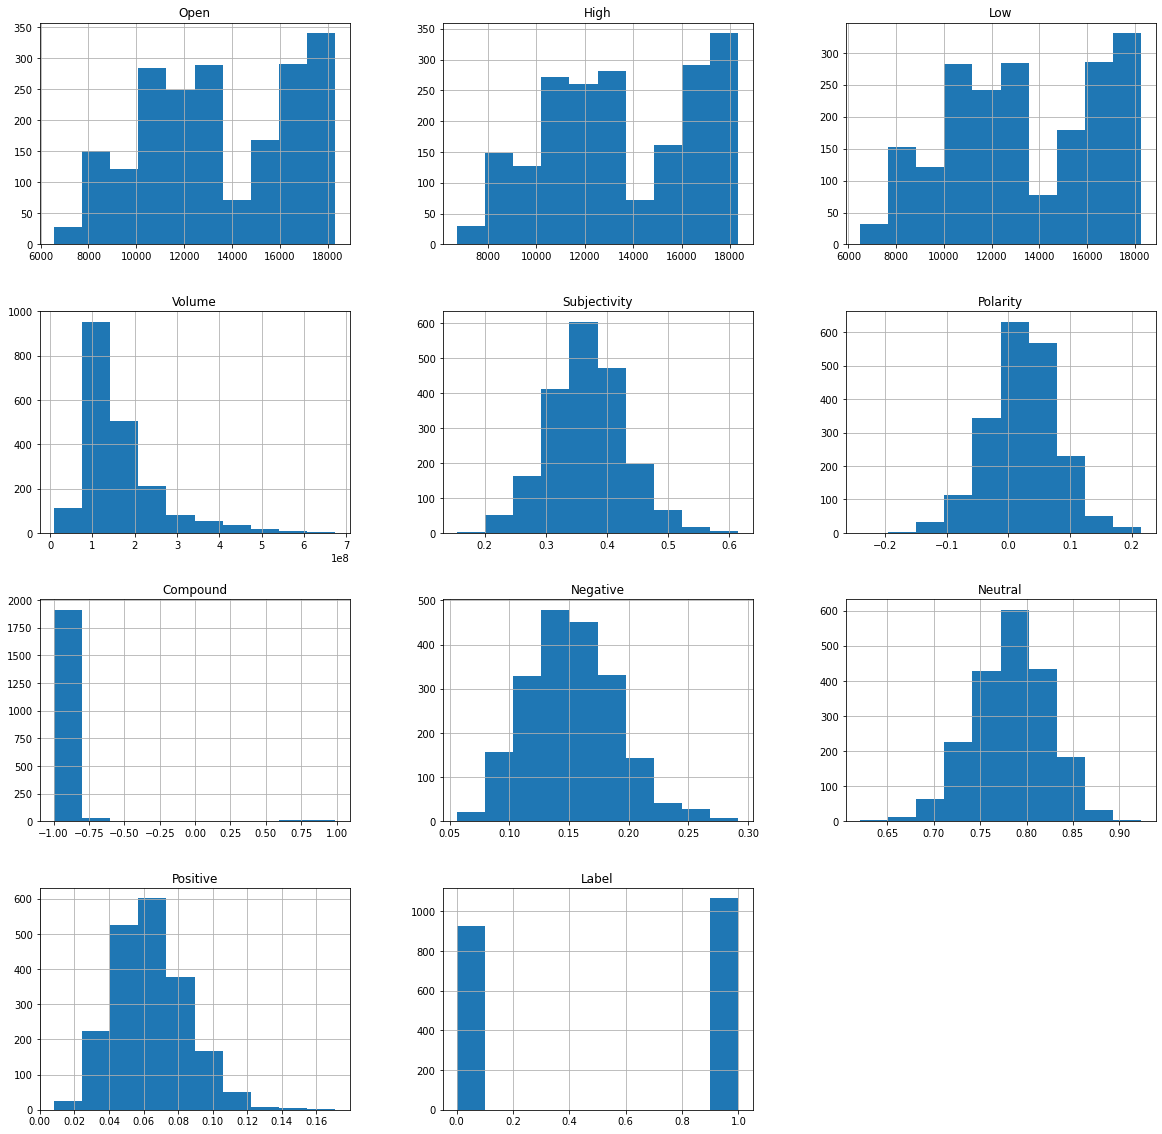

In [16]:
dataset.hist(figsize=(20, 20))

## Matrice de correlation

<AxesSubplot:>

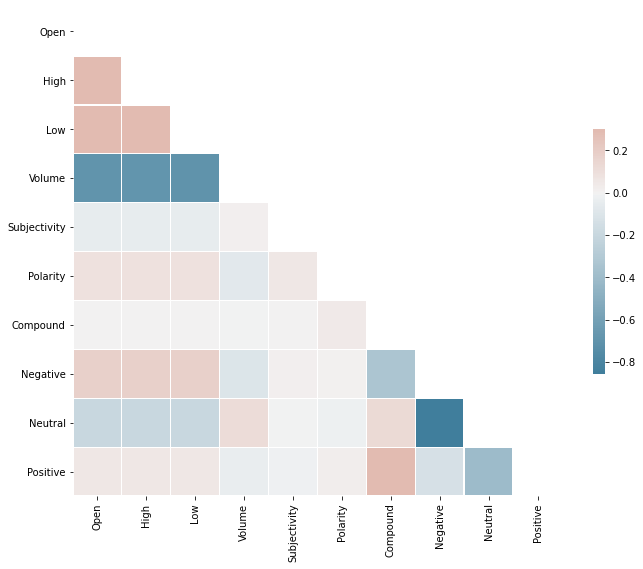

In [17]:
corr = dataset.drop(['Label'],1).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Application d'algorithmes de classification

In [18]:
X = dataset
X = np.array(X.drop(['Label'], 1))
y = np.array(dataset['Label'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.36, random_state=42)
# dictionaire qui contiendra les scores f1
f1 = {}         
# dictionaire qui contiendra les scores froc_auc
rocauc = {} 

In [20]:
def train_eval_model(model, f1dict, rocaucDict, name):
    """
    Ceci est une fonction qui sera utilsée pour entrainer et 
    évaluer chaque model.
    """
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1dict[name] = f1_score(y_test, y_pred)
    rocaucDict[name] = roc_auc_score(y_test, y_pred)

### eXtreme Gradient Boosting Classifier

In [21]:
xgb_cls = Pipeline([
    ("scaler", StandardScaler()),
    ('xgb', XGBClassifier(subsample=0.55, sampling_method='uniform', reg_lambda=5, reg_alpha=1, 
                        n_estimators=550, min_child_weight=0.01, max_depth=None, learning_rate=0.5, 
                        gamma=1, colsample_bytree=0.85))
])

train_eval_model(xgb_cls, f1, rocauc, 'XGBClassifier')

[21:23:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### Random Forest Classifier

In [22]:
rndf_clf_scal = Pipeline([
    ("scaler", StandardScaler()),
    ("rndf", RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2', 
                                    min_samples_leaf=3, min_samples_split=2, n_estimators=100))
])

train_eval_model(rndf_clf_scal, f1, rocauc, 'RandomForestClassifier')

### Ada Boost Classifier

In [23]:
ada_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("adb", AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=500,
                             algorithm="SAMME.R", learning_rate=0.5))
])
train_eval_model(ada_clf, f1, rocauc, 'AdaBoostClassifier')

### SVM Classifier

In [24]:
svm_clf_scal = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=100, loss='squared_hinge', max_iter=17000))
])

train_eval_model(svm_clf_scal, f1, rocauc, 'LinearSVC')

### Linear Discriminant Analysis

In [25]:
LDA_cls = Pipeline([
    ("scaler", StandardScaler()),
    ("LDA", LinearDiscriminantAnalysis())
])

train_eval_model(LDA_cls, f1, rocauc, 'LinearDiscriminantAnalysis')

## Comparaison des models - performance

Text(0.5, 1.0, 'Score f1')

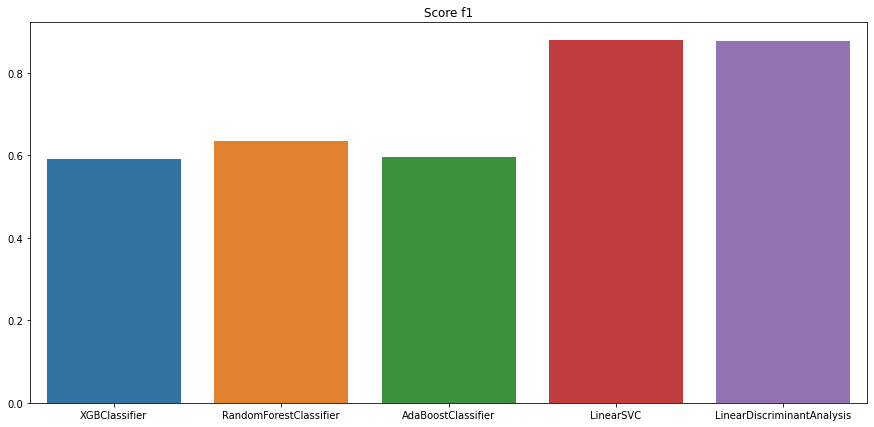

In [26]:
plt.rcParams['figure.figsize']=(15,7)
sns.barplot(data=pd.DataFrame(f1, index=[0])).set_title("Score f1")

Text(0.5, 1.0, 'ROC AUC')

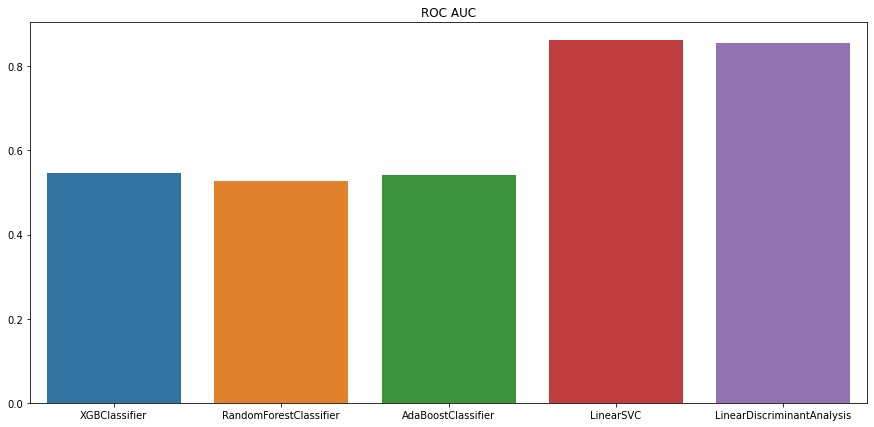

In [27]:
plt.rcParams['figure.figsize']=(15,7)
sns.barplot(data=pd.DataFrame(rocauc, index=[0])).set_title("ROC AUC")

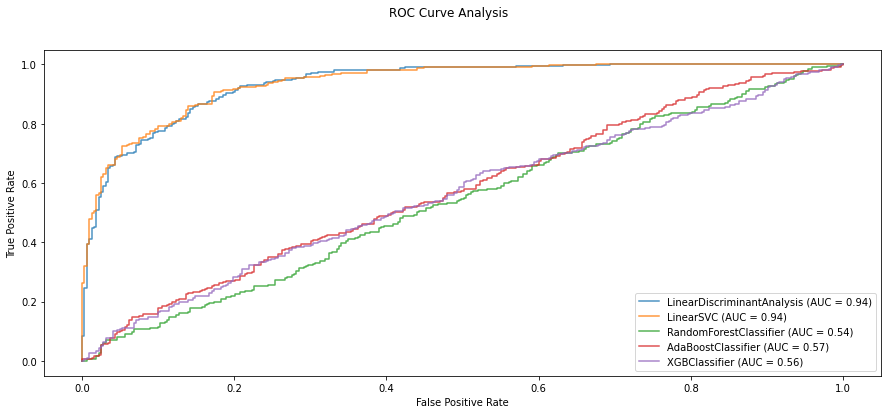

In [28]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('ROC Curve Analysis')
ax = plt.gca()

plot_roc_curve(LDA_cls, X_test, y_test,ax=ax, alpha=0.8, name='LinearDiscriminantAnalysis')
plot_roc_curve(svm_clf_scal, X_test, y_test, ax=ax, alpha=0.8, name='LinearSVC')
plot_roc_curve(rndf_clf_scal, X_test, y_test, ax=ax, alpha=0.8, name='RandomForestClassifier')
plot_roc_curve(ada_clf, X_test, y_test, ax=ax, alpha=0.8, name='AdaBoostClassifier')
plot_roc_curve(xgb_cls, X_test, y_test, ax=ax, alpha=0.8, name='XGBClassifier')

plt.show()